In [1]:
SMALL_SIZE, MEDIUM_SIZE = 9, 12
PROJECT_PATH = "/Users/donghur/Desktop/Research/Murthy/BM_GPU"
PROJECT_PATH_BMGPU = "/Users/donghur/Desktop/Research/Murthy/BM_GPU"

In [2]:
import sys
import pickle
import numpy as np
from glob import glob
import random, matplotlib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

sys.path.append(PROJECT_PATH)
from utils.data import Dataset


In [3]:
import utils.figure as ufigure
%load_ext autoreload
%autoreload 1
%aimport utils.data
%aimport utils.figure

In [4]:
config_path = f"{PROJECT_PATH_BMGPU}/config_ant.yaml"
Data = Dataset(PROJECT_PATH, config_path)
Data.load_data()

Loading config.yaml ...
Finished loading config
Loading INFO.yaml ...
Finished loading INFO


100%|██████████| 141/141 [00:31<00:00,  4.53it/s]


In [5]:
# configuration
INFO = Data.info
INFO_values = Data.info_values
config = Data.config
skeleton = config['skeleton']
skeleton_color= config['skeleton_color']

# features
bp = Data.data_obj['bodypoints']
rot_bp = Data.data_obj['rotated_bodypoints']
angles = Data.data_obj['angles']
limbs = Data.data_obj['limbs']
angle_power = Data.data_obj['angle_power']
limb_power = Data.data_obj['limb_power']

# embeddings
all_embed = Data.data_obj['all_embeddings']
all_postural_embed = Data.data_obj['all_postural_embeddings']
all_kinematic_embed = Data.data_obj['all_kinematic_embeddings']

with open (f"{PROJECT_PATH_BMGPU}/{config['result_path']}/limb_scale_model.pickle", 'rb') as file:
    limb_scaler = pickle.load(file)

/Users/donghur/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Overview

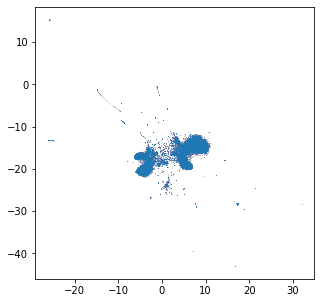

In [35]:
fig_all_embed, ax_all_embed = plt.subplots(1,1,figsize=(5,5))
ax_all_embed.scatter(all_embed[:,0], all_embed[:,1], s=1, alpha=0.005)
plt.show()

In [36]:
# Global parameter for the rest of the embeddings
ax_x_length = np.diff(ax_all_embed.get_xlim())[0]
ax_y_length = np.diff(ax_all_embed.get_ylim())[0]

def fix_aspect_ratio(xlim, ylim):
    d = np.diff(xlim)[0]*ax_y_length/ax_x_length - np.diff(ylim)[0]
    return xlim, (ylim[0]-d/2, ylim[1]+d/2)

def plot_embedding(embed, xlim, ylim, frac_pts=1/3, scatter_s=1, scatter_alpha=0.04, kde_gridsize=200):
    num_fr = len(embed)
    idx = random.choices(np.arange(num_fr), k=int(num_fr*frac_pts))
    
    # Scatter Plot
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].scatter(embed[idx,0], embed[idx,1], s=scatter_s, alpha=scatter_alpha)
    ax[0].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding", xlim=xlim,ylim=ylim)

    # Density Plot
    sns.kdeplot(x=embed[idx,0], y=embed[idx,1], 
                shade=True, thresh=0, gridsize=kde_gridsize, bw_adjust=0.3,
                levels=100, cmap='viridis',
                cbar=False, ax=ax[1])
    ax[1].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding", facecolor='#440054', 
                        xlim=xlim ,ylim=ylim)
    plt.show()

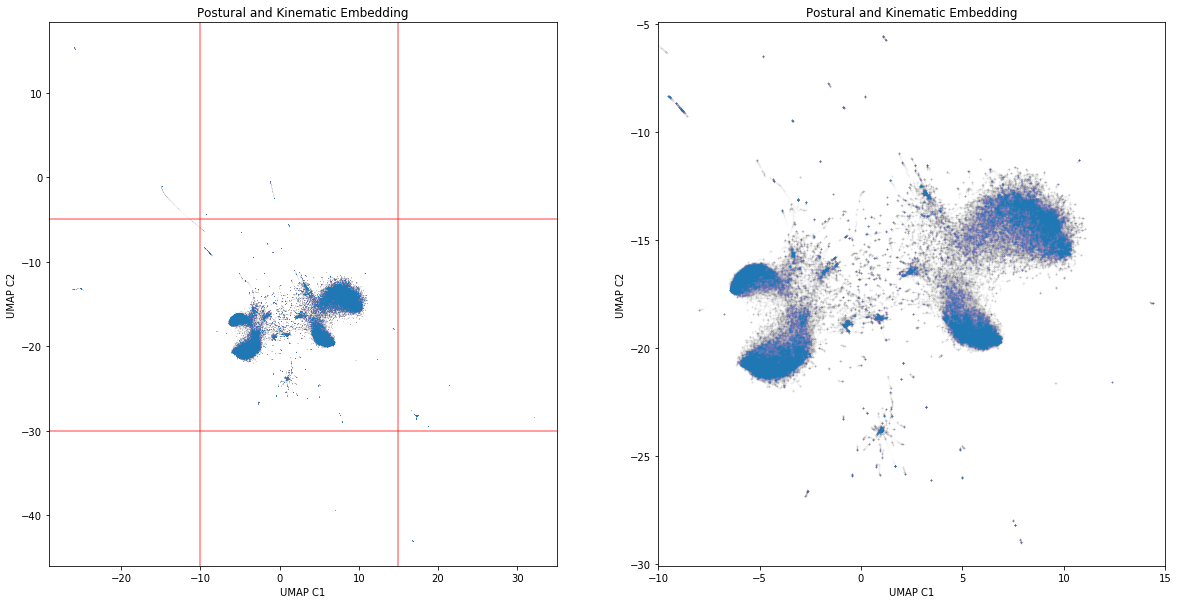

In [8]:
region_x_lim, region_y_lim = (-10,15), (-30,-5)
region_x_lim, region_y_lim = fix_aspect_ratio(region_x_lim, region_y_lim)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].scatter(all_embed[:,0], all_embed[:,1], s=1, alpha=0.005)
ax[0].set(xlabel="UMAP C1", ylabel="UMAP C2", title="Postural and Kinematic Embedding")
for x,y in zip(region_x_lim, region_y_lim):
    ax[0].axhline(y=y, color='r', alpha=0.5)
    ax[0].axvline(x=x, color='r', alpha=0.5)
ax[1].scatter(all_embed[:,0], all_embed[:,1], s=1.5, alpha=0.002)
ax[1].set(xlabel="UMAP C1", ylabel="UMAP C2", title="Postural and Kinematic Embedding",xlim=region_x_lim, ylim=region_y_lim)
plt.show()

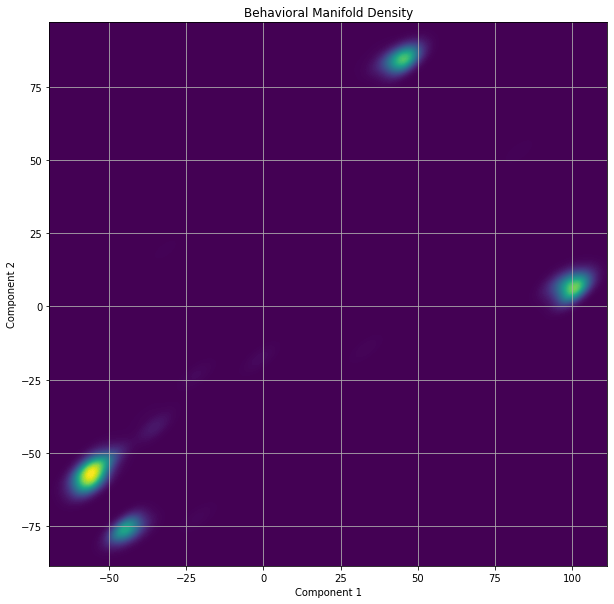

In [12]:
import seaborn as sns

good_fr, _ = np.where(~np.isnan(all_embed))

fig_dense, ax_density = plt.subplots(figsize=(10, 10))
sns.kdeplot(x=all_embed[good_fr,0], y=all_embed[good_fr,1], 
            shade=True, thresh=0, gridsize=300, bw_adjust=0.5,
            levels=100, cmap='viridis',
            cbar=False, ax=ax_density)
ax_density.set(xlabel='Component 1', ylabel='Component 2', title="Behavioral Manifold Density", facecolor='#440054', xlim=ax_all_embed.get_xlim(), ylim=ax_all_embed.get_ylim())
ax_density.grid(which="major")
plt.show()

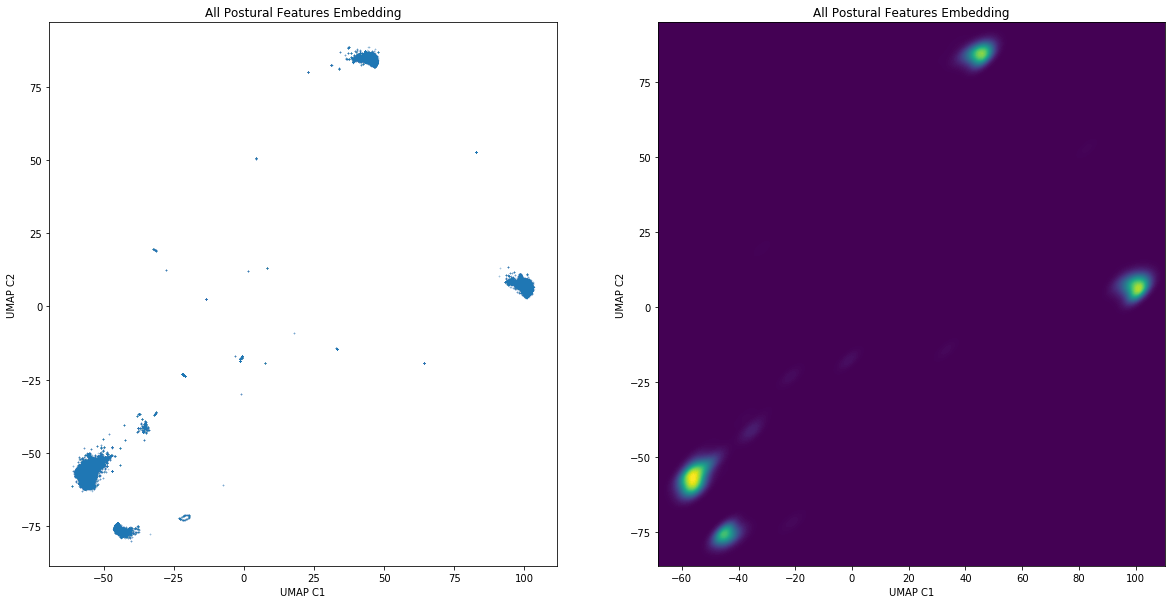

In [13]:
### Region 1
# find figure bounds
region_x_lim, region_y_lim = None, None #(-4,8.5), (-6.5,3)
# region_x_lim, region_y_lim = fix_aspect_ratio(region_x_lim, region_y_lim)

# plot region 1
plot_embedding(all_embed, region_x_lim, region_y_lim, frac_pts=1/2, 
               scatter_s=1, scatter_alpha=0.025, 
               kde_gridsize=300)

# Watershed Clustering

In [9]:
from cluster import Watershed
from sklearn.utils import shuffle
%load_ext autoreload
%autoreload 1
%aimport cluster

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
num_fr, num_dim = all_embed.shape
nan_fr, nan_dim = np.where(np.isnan(all_embed))
np_unique_fr = np.unique(nan_fr)
good_fr = np.array([True]*num_fr)
good_fr[np_unique_fr] = False

good_all_embed = all_embed[good_fr]

In [52]:
all_embed.shape

(1872138, 2)

In [51]:
good_all_embed.shape

(607119, 2)

Creating 2D Grid System...(1/7)
Computing Gaussian Kernel...(2/7)
Finding Data Point Coordinates...(3/7)
Finding Local Max Basin Point...(4/7)
Creating Mask...(5/7)
Finding Watershed...(6/7)
Creating Watershed label...(7/7)
COMPLETE


/Users/donghur/anaconda3/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


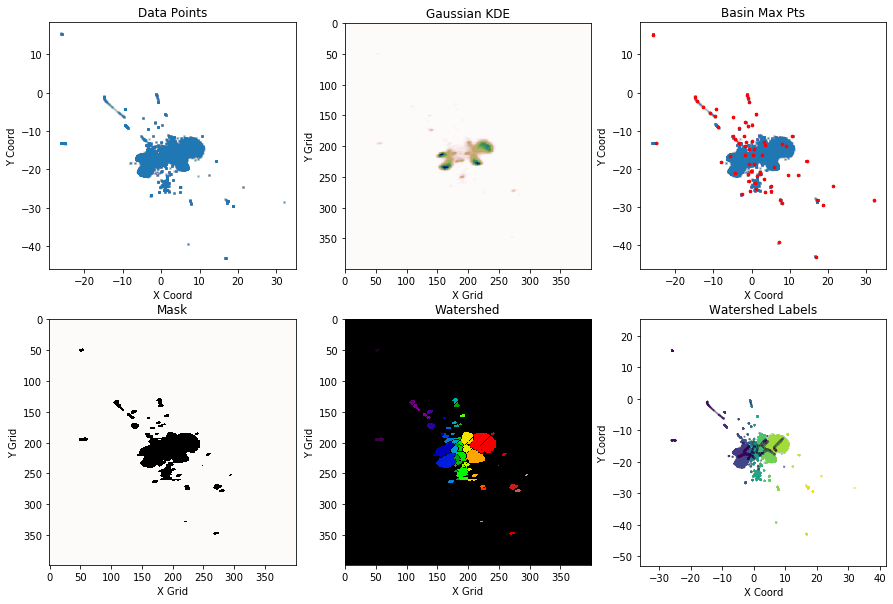

In [14]:
watershed_labels = Watershed(data=good_all_embed, grid_dim=400, bw_method=0.08, ROI_thresh=0.0001, grid_padding=10, verbose=True, fig_alpha=0.01, fig_s=2, watershed_line=True)


In [16]:
np.max(watershed_labels)

65.0

In [27]:
import os

full_label = np.ones(num_fr)*-1
full_label[good_fr] = watershed_labels

for val in INFO_values:
    start_fr, stop_fr = val['global_start_fr'], val['global_stop_fr']
    save_path = f"/Users/donghur/Desktop/Research/Murthy/BM_GPU/{val['directory']}"
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    np.save(f"{save_path}/cluster.npy", full_label[start_fr:stop_fr])

# Understanding the Clusters

In [55]:
cluster = Data.data_obj['cluster']
num_clusters = int(np.max(cluster)+1)

num_fr, num_dim = all_embed.shape
nan_fr, nan_dim = np.where(np.isnan(all_embed))
np_unique_fr = np.unique(nan_fr)
good_fr = np.array([True]*num_fr)
good_fr[np_unique_fr] = False

good_all_embed = all_embed[good_fr]

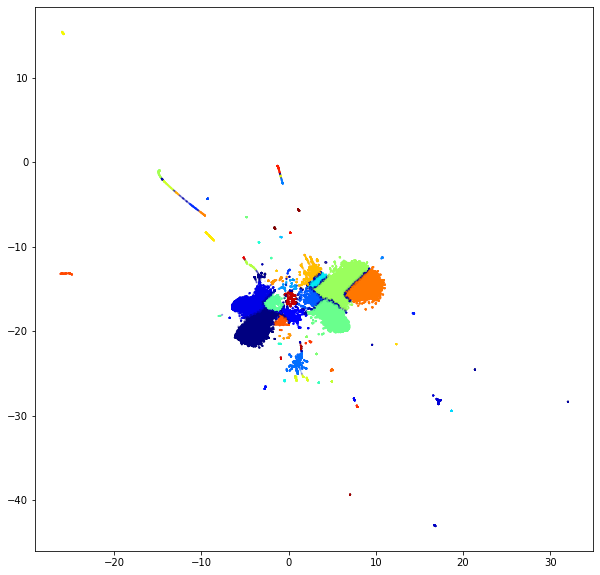

In [32]:
vals = np.linspace(0,1,num_clusters)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.jet(vals))

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(all_embed[:,0], all_embed[:,1], s=1, alpha=0.1, c=cluster, cmap=cmap)
plt.show()

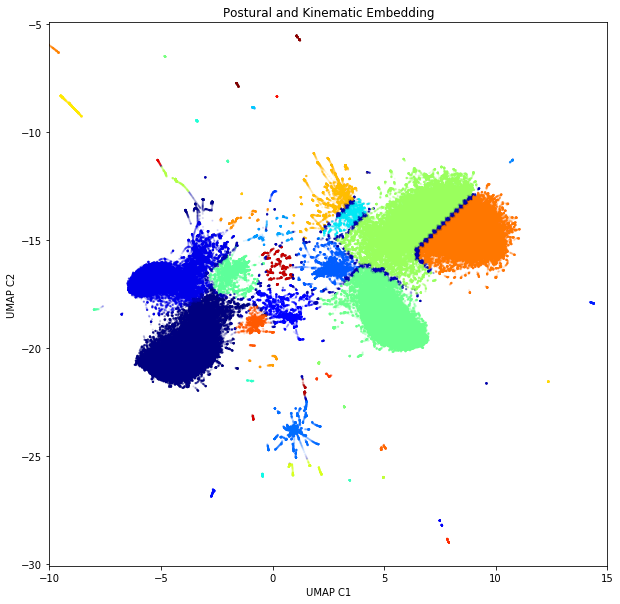

In [41]:
region_x_lim, region_y_lim = (-10,15), (-30,-5)
region_x_lim, region_y_lim = fix_aspect_ratio(region_x_lim, region_y_lim)

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(all_embed[:,0], all_embed[:,1], s=1.5, alpha=0.1, c=cluster, cmap=cmap)
ax.set(xlabel="UMAP C1", ylabel="UMAP C2", title="Postural and Kinematic Embedding",xlim=region_x_lim, ylim=region_y_lim)
plt.show()

 79%|███████▉  | 52/66 [00:00<00:00, 124.69it/s]/Users/donghur/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/donghur/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
100%|██████████| 66/66 [00:00<00:00, 10027.31it/s]


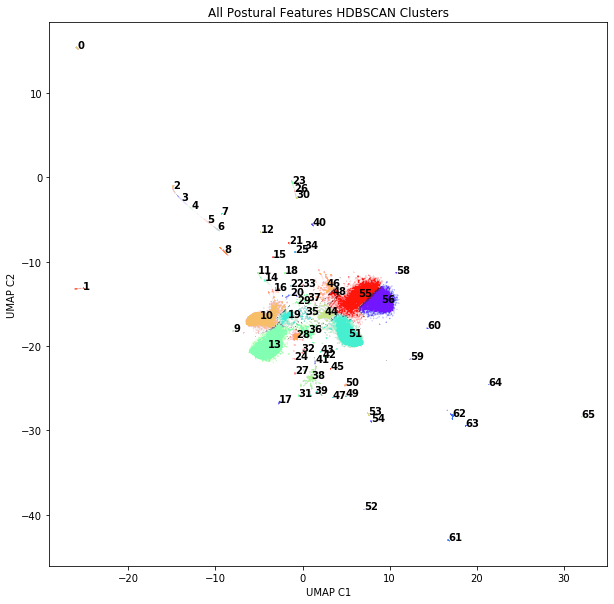

In [48]:
import seaborn as sns
from sklearn.utils import shuffle
from utils.figure import plot_HDBSCAN

color_palette = sns.color_palette('rainbow', int(num_clusters))
color_palette = shuffle(color_palette, random_state=1)

fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_HDBSCAN(ax, all_embed, cluster, color_palette, marker_size=1, alpha=0.005, xlim=None, ylim=None, toggle_numbering=True)
plt.show()

100%|██████████| 49/49 [00:00<00:00, 10989.25it/s]


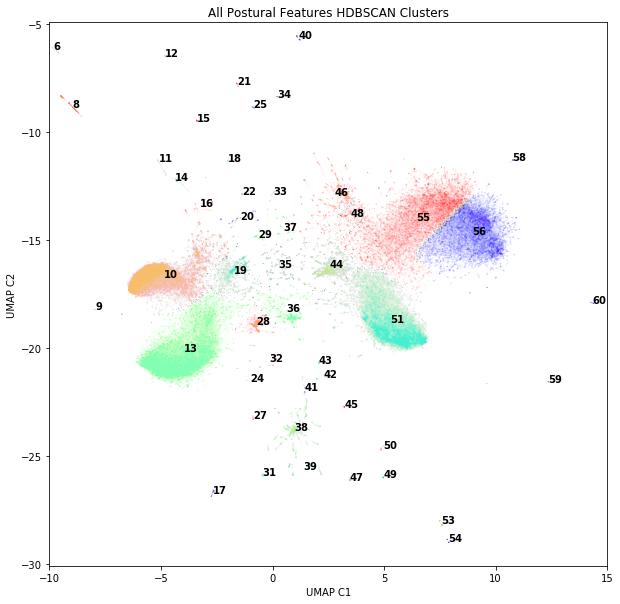

In [49]:
region_x_lim, region_y_lim = (-10,15), (-30,-5)
region_x_lim, region_y_lim = fix_aspect_ratio(region_x_lim, region_y_lim)

fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_HDBSCAN(ax, all_embed, cluster, color_palette, marker_size=1, alpha=0.005, xlim=region_x_lim, ylim=region_y_lim, toggle_numbering=True)
plt.show()

# Caste

In [57]:
caste_data = {"min": [], "mid": [], "maj":[]}
env_data = {"food": [], "free":[]}

caste_cluster = {"min": [], "mid": [], "maj":[]}
env_cluster = {"food": [], "free": []}

# cluster = full_label
for item in INFO_values:
    path = item['directory']
    start, stop = item['global_start_fr'], item['global_stop_fr']

    # Caste Condition
    if path.find("min") is not -1:
        caste_data["min"].extend(all_embed[start:stop].tolist())
        caste_cluster["min"].extend(cluster[start:stop].tolist())
    if path.find("mid") is not -1:
        caste_data["mid"].extend(all_embed[start:stop].tolist())
        caste_cluster["mid"].extend(cluster[start:stop].tolist())
    if path.find("maj") is not -1:
        caste_data["maj"].extend(all_embed[start:stop].tolist())
        caste_cluster["maj"].extend(cluster[start:stop].tolist())
    
    # Environmental Conditionse
    if path.find("fd") is not -1:
        env_data["food"].extend(all_embed[start:stop].tolist())
        env_cluster["food"].extend(cluster[start:stop].tolist())
    if path.find("fr") is not -1:
        env_data["free"].extend(all_embed[start:stop].tolist())
        env_cluster["free"].extend(cluster[start:stop].tolist())

In [66]:
caste_data["mid"] = np.array(caste_data["mid"])

In [67]:
num_fr, num_dim = caste_data["mid"].shape
nan_fr, nan_dim = np.where(np.isnan(caste_data["mid"]))
np_unique_fr = np.unique(nan_fr)
good_fr = np.array([True]*num_fr)
good_fr[np_unique_fr] = False

In [68]:
np.where(good_fr)[0].shape

(144509,)

In [69]:
num_fr

618586

(505934, 2)
(618586, 2)
(661457, 2)


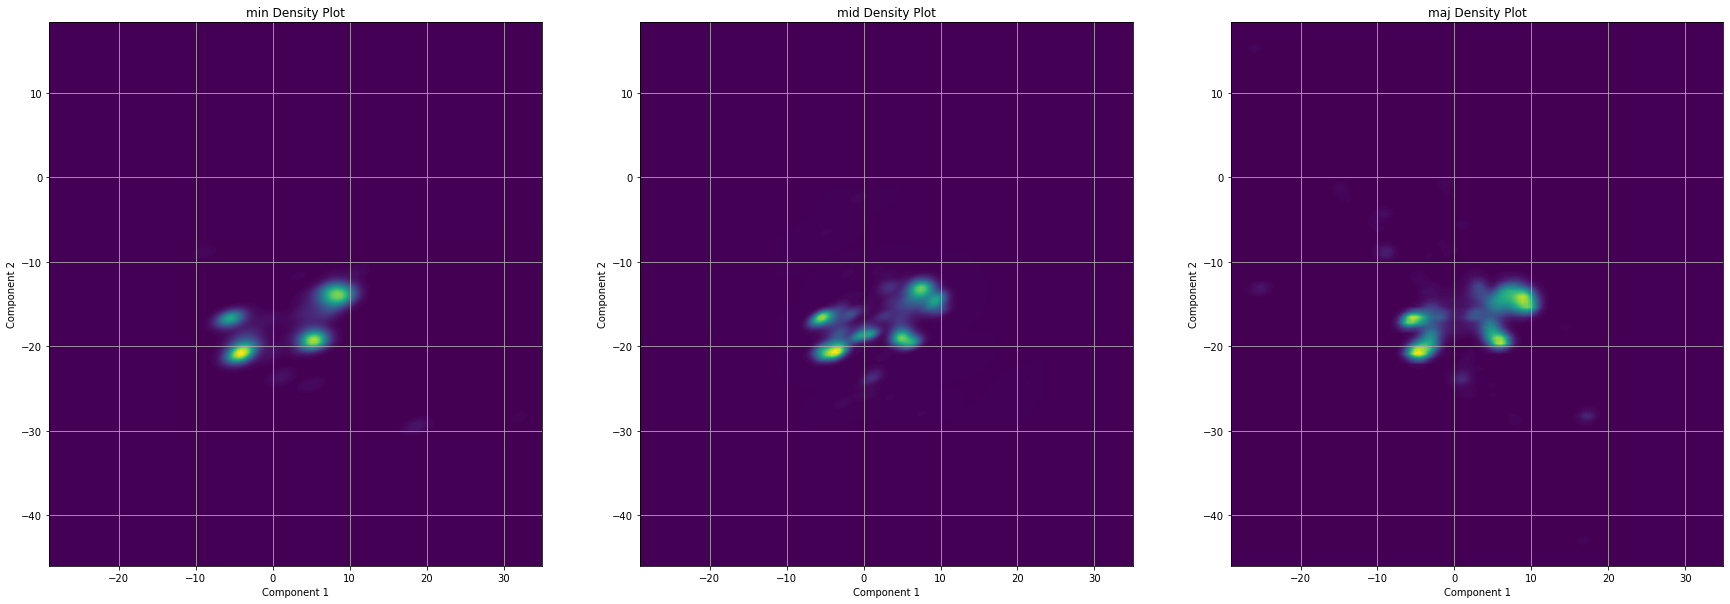

In [33]:
import seaborn as sns

# caste
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
for idx, (key, cat_embed) in enumerate(caste_data.items()):
    cat_embed = np.array(cat_embed)
    print(cat_embed.shape)
    num_fr,_ = cat_embed.shape
    nan_fr,_ = np.where(np.isnan(cat_embed))
    bad_fr = np.unique(nan_fr)
    good_fr = np.array([True]*num_fr)
    good_fr[bad_fr] = False
    # density
    sns.kdeplot(x=cat_embed[good_fr,0], y=cat_embed[good_fr,1], 
            shade=True, thresh=0, gridsize=100, bw_adjust=1,
            levels=100, cmap='viridis',
            cbar=False, ax=ax[idx])
    
    ax[idx].set(xlabel='Component 1', ylabel='Component 2', 
                title=f"{key} Density Plot", facecolor='#440054',
               xlim=ax_all_embed.get_xlim(), ylim=ax_all_embed.get_ylim()) # , facecolor='#000096'
    ax[idx].grid(which="major")
plt.show()

# Motif Usage

In [30]:
import collections

num_clusters = np.max(cluster) + 1
caste_motif = {"min": [], "mid": [], "maj":[]}

for key in caste_cluster.keys():
    print(key)
    
    for clust_id in np.arange(-2,num_clusters):
        clust_fr, = np.where( caste_cluster[key]==clust_id )
        caste_motif[key].append(len(clust_fr))
    
    cluster_num_fr_norm = 100*np.array(caste_motif[key])/np.sum(caste_motif[key])
    caste_motif[key] = cluster_num_fr_norm
    print(caste_motif)

min
{'min': array([0.00000000e+00, 9.41039740e+01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.52193764e-02, 0.00000000e+00,
       6.88627370e-01, 0.00000000e+00, 0.00000000e+00, 1.65298240e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.87771528e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.95677697e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.52258990e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.18223326e-02, 0.00000000e+00,
       0.00000000e+00, 2.01607324e-02, 0.00000000e+00, 0.00000000e+00,
       4.28909700e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.95677697e-02, 0.00000000e+00,
       8.10382382e-03, 0.00000000e+00, 1.97654239e-04, 0.00000000e+00,
       2.31255460e-02, 1.37488289e+00, 0.00000000e+00, 0.00000000

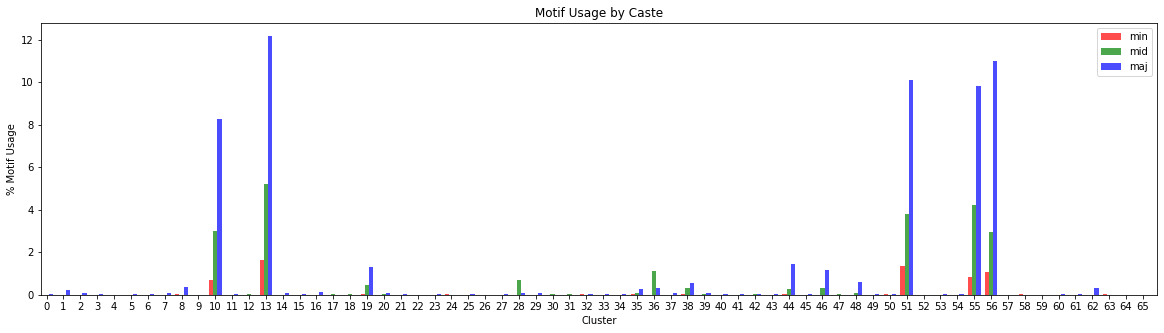

In [31]:
# Distribution figure  
cluster_id = np.arange(0,num_clusters*12)
width = 3

fig, ax = plt.subplots(figsize=(20,5)) 
ax.bar(cluster_id[0::12], caste_motif['min'][2:],color='red',width=width,label='min',alpha=0.7)
ax.bar(cluster_id[3::12], caste_motif['mid'][2:],color='green',width=width,label='mid',alpha=0.7)
ax.bar(cluster_id[6::12], caste_motif['maj'][2:],color='blue',width=width,label='maj',alpha=0.7)
ax.set(xlabel="Cluster", ylabel="% Motif Usage", title="Motif Usage by Caste", 
       xticks=cluster_id[3::12], xticklabels=np.arange(0,num_clusters).astype(int),
      xlim=[-1,num_clusters*12+1])
plt.legend()
plt.show()

# Region 1: Deeper Analysis

In [31]:
import seaborn as sns
from sklearn.utils import shuffle
from utils.figure import plot_HDBSCAN

labels = Data.data_obj['cluster']
num_clusters = int(np.max(labels)+1)
color_palette = sns.color_palette('rainbow', int(num_clusters))
color_palette = shuffle(color_palette, random_state=1)

region_x_lim, region_y_lim = (35,50), (75,95)
region_x_lim, region_y_lim = fix_aspect_ratio(region_x_lim, region_y_lim)

100%|██████████| 5/5 [00:00<00:00, 2842.44it/s]


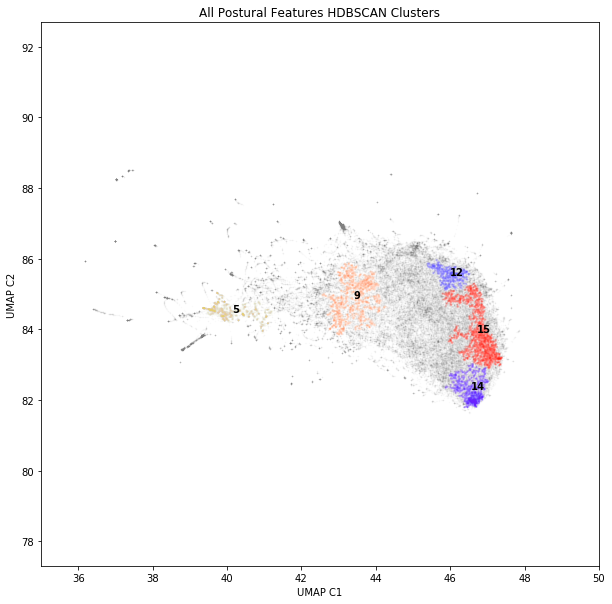

In [32]:
fig, ax = plt.subplots(figsize=(10,10))
plot_HDBSCAN(ax, all_embed, labels, color_palette, alpha=0.02, xlim=region_x_lim, ylim=region_y_lim, toggle_numbering=True)
plt.show()

In [33]:
x_bound_cond = (all_embed[:,0]>region_x_lim[0]) & (all_embed[:,0]<region_x_lim[1])
y_bound_cond = (all_embed[:,1]>region_y_lim[0]) & (all_embed[:,1]<region_y_lim[1])

region_fr_idx, = np.where(x_bound_cond & y_bound_cond)

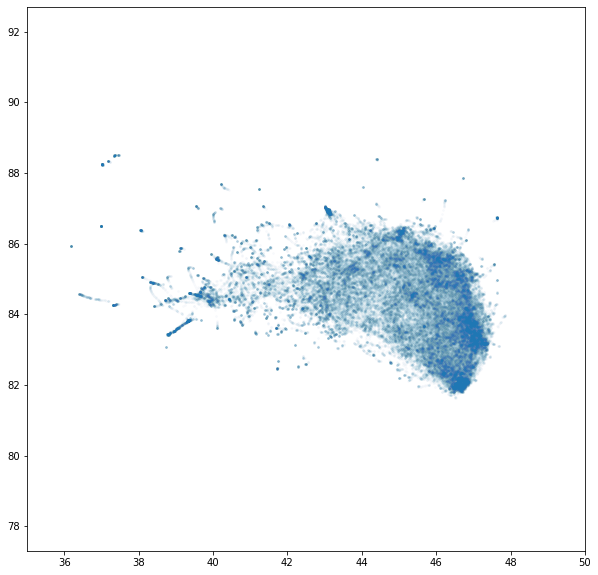

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(all_embed[region_fr_idx,0], all_embed[region_fr_idx,1], alpha=0.02, s=3)
ax.set(xlim=region_x_lim, ylim=region_y_lim)
plt.show()

## Postural

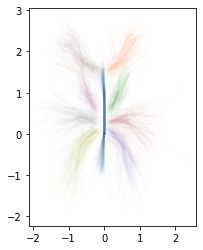

In [58]:
fig, ax = plt.subplots(figsize=(3,4))

rand_idx = shuffle(region_fr_idx)[:100]
# plot bodypoints
# ax.scatter(rot_bp[rand_idx,:,0], rot_bp[rand_idx,:,1], alpha=0.1, s=7, c='k')
# ax.set(title=f"Ant Model Bodypoints", xlabel="scaled x coord", ylabel="scaled y coord")

# plot skeleton
if (skeleton is not None) and (skeleton_color is not None):
    for skeleton_i, color_i in zip(skeleton, skeleton_color):
        for fr in rand_idx:
            ax.plot(rot_bp[fr,skeleton_i,0], rot_bp[fr,skeleton_i,1], alpha=0.01, c=color_i, linewidth=2)
plt.show()

## Kinematic

In [61]:
max_freq, min_freq = 1/config['period_min'], 1/config['period_max'] # Nyquist Frequency
freq = max_freq*2**(-1*np.log2(max_freq/min_freq)*
    (np.arange(config['f_bin'],0,-1)-1)/(config['f_bin']-1)) # dyadic frequency bins

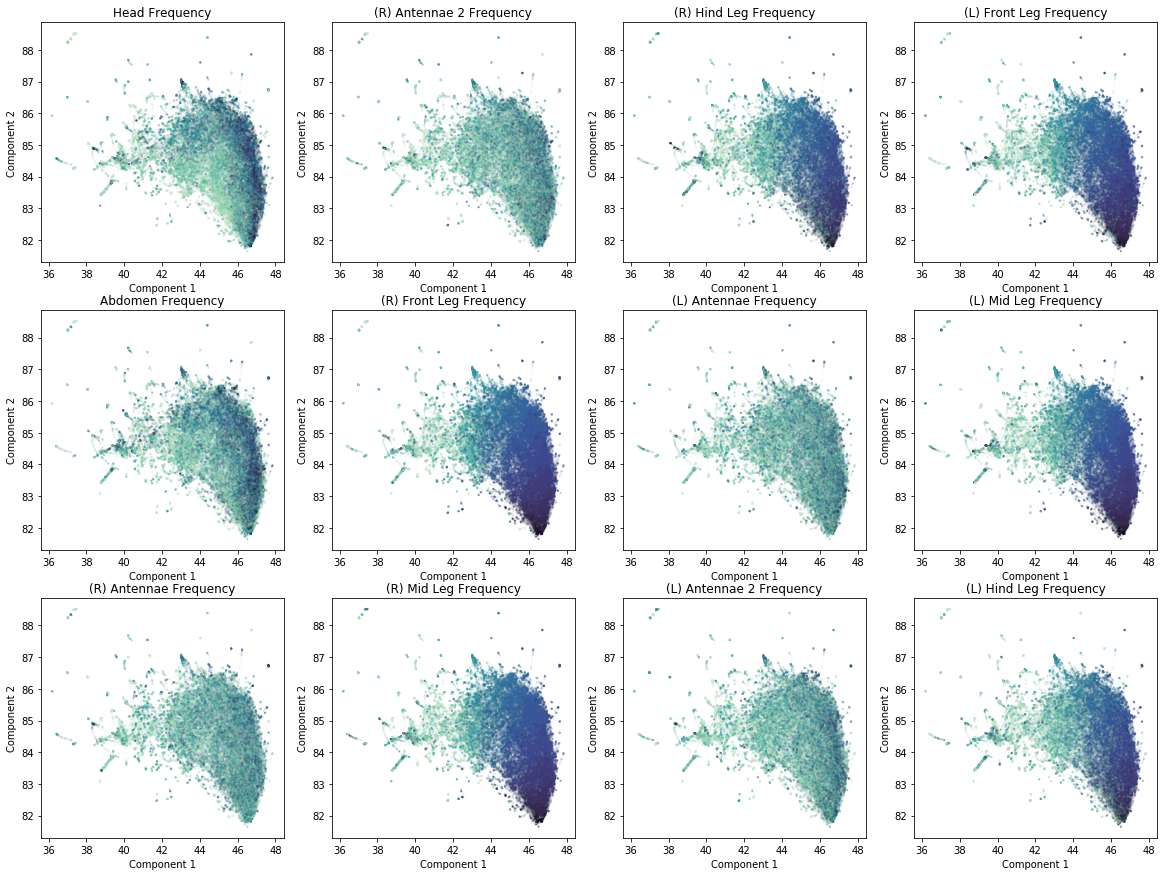

In [64]:
# Figure Information
max_freq_idx = np.argmax(angle_power[:,:,:], axis=1)
max_freq = freq[max_freq_idx]
num_freq = len(freq)

# Freq Color Scheme
freq_color_palette = sns.color_palette('mako_r', num_freq)
cmap1, norm1 = matplotlib.colors.from_levels_and_colors(freq, freq_color_palette, extend="max")

# Figures
fig, ax = plt.subplots(3,4, figsize=(20,15))
for angle_idx in tqdm(range(12)):
    fig_title = f"{config['angle_labels'][angle_idx]} Frequency"
    freq_cluster_colors = np.array([freq_color_palette[f] for f in max_freq_idx[region_fr_idx,angle_idx]])

    ax[angle_idx%3, angle_idx//3].scatter(all_embed[region_fr_idx,0], all_embed[region_fr_idx,1], color=freq_cluster_colors, alpha=0.05, s=1.5)  
    ax[angle_idx%3, angle_idx//3].set(xlabel='Component 1', ylabel='Component 2', title=fig_title) # xlim=region_x_lim, ylim=region_y_lim

plt.show()

In [84]:
import seaborn as sns
from sklearn.utils import shuffle
from utils.figure import plot_HDBSCAN
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

In [26]:
region_x_lim, region_y_lim = (35,50), (75,95)
region_x_lim, region_y_lim = fix_aspect_ratio(region_x_lim, region_y_lim)

x_bound_cond = (all_embed[:,0]>region_x_lim[0]) & (all_embed[:,0]<region_x_lim[1])
y_bound_cond = (all_embed[:,1]>region_y_lim[0]) & (all_embed[:,1]<region_y_lim[1])

region_fr_idx, = np.where(x_bound_cond & y_bound_cond)
region_embed = all_embed[region_fr_idx,:]

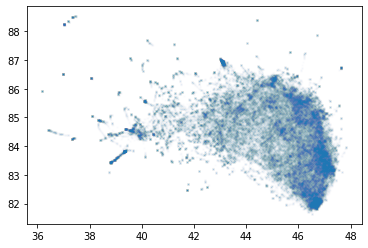

In [27]:
plt.scatter(region_embed[:,0], region_embed[:,1], alpha=0.01,s=2)
plt.show()

In [89]:
gmm = BayesianGaussianMixture(n_components=100, random_state=0, weight_concentration_prior=0.001).fit(region_embed)
labels = gmm.predict(region_embed)

/Users/donghur/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [90]:
np.max(labels)+1

100

In [34]:
gmm_prob = gmm.predict_proba(region_embed)

In [82]:
thresh = 0.6

num_fr = len(gmm_prob)
prob_labels = np.zeros(num_fr)
for i_fr in range(num_fr):
    if any(gmm_prob[i_fr]>thresh):
        prob_labels[i_fr] = np.argmax(gmm_prob[i_fr])
    else:
        prob_labels[i_fr] = -1

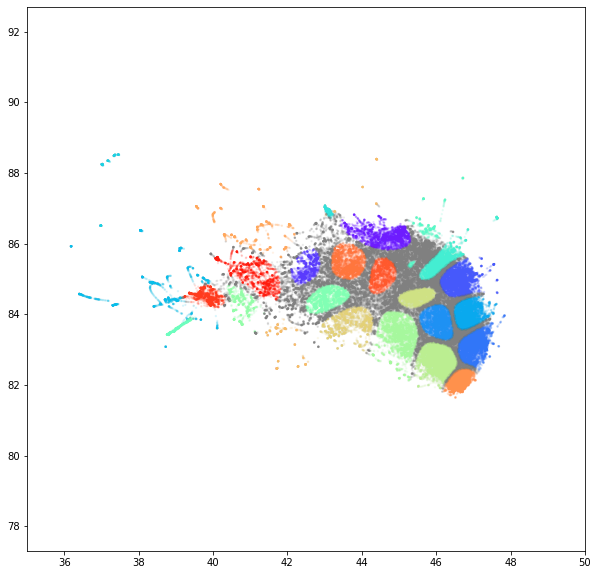

In [83]:
cluster = prob_labels

# define coloring
region_num_clusters = np.max(cluster)+1
color_palette = sns.color_palette('rainbow', int(region_num_clusters))
color_palette = shuffle(color_palette, random_state=1)
cluster_colors = np.array([color_palette[int(x)] if int(x) >= 0
                      else (0.5, 0.5, 0.5)
                      for x in cluster])
# create figure
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(region_embed[:,0], region_embed[:,1], alpha=0.1, s=2, c=cluster_colors)
ax.set(xlim=region_x_lim, ylim=region_y_lim)
plt.show()

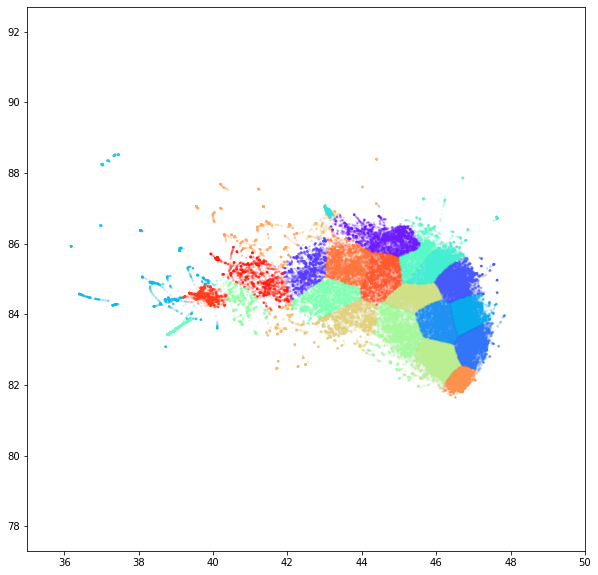

In [81]:
cluster = labels

# define coloring
region_num_clusters = np.max(cluster)+1
color_palette = sns.color_palette('rainbow', int(region_num_clusters))
color_palette = shuffle(color_palette, random_state=1)
cluster_colors = np.array([color_palette[int(x)] if int(x) >= 0
                      else (0.5, 0.5, 0.5)
                      for x in cluster])
# create figure
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(region_embed[:,0], region_embed[:,1], alpha=0.1, s=2, c=cluster_colors)
ax.set(xlim=region_x_lim, ylim=region_y_lim)
plt.show()

In [85]:
aic_list = []
bic_list = []
for i_cluster in tqdm(np.arange(1,50)):
    gmm = GaussianMixture(n_components=i_cluster, random_state=0).fit(region_embed)
    aic_list.append( gmm.aic(region_embed) )
    bic_list.append( gmm.bic(region_embed) )


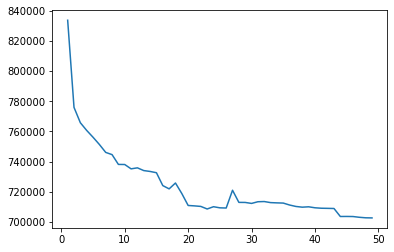

In [87]:
plt.plot(np.arange(1,50), aic_list)
plt.show()

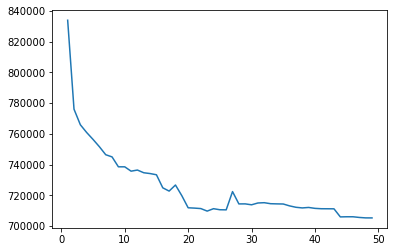

In [88]:
plt.plot(np.arange(1,50), bic_list)
plt.show()

In [89]:
bic_list[25:35]

[710596.4933531922,
 722466.3426749832,
 714456.7391446511,
 714477.8784772241,
 713887.8229569776,
 715058.8648269209,
 715249.2827422051,
 714597.4905647207,
 714480.8069040041,
 714402.1022788065]

# Region 1: Watershed Clustering

In [14]:
import seaborn as sns
from sklearn.utils import shuffle

from utils.figure import plot_HDBSCAN
from cluster import Watershed
%load_ext autoreload
%autoreload 1
%aimport cluster

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


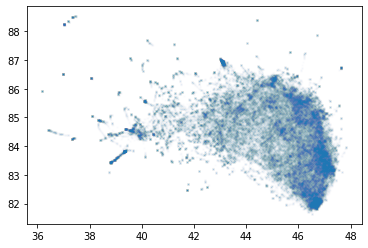

In [18]:
region_x_lim, region_y_lim = (35,50), (75,95)
region_x_lim, region_y_lim = fix_aspect_ratio(region_x_lim, region_y_lim)

x_bound_cond = (all_embed[:,0]>region_x_lim[0]) & (all_embed[:,0]<region_x_lim[1])
y_bound_cond = (all_embed[:,1]>region_y_lim[0]) & (all_embed[:,1]<region_y_lim[1])

region_fr_idx, = np.where(x_bound_cond & y_bound_cond)
region_embed = all_embed[region_fr_idx,:]

plt.scatter(region_embed[:,0], region_embed[:,1], alpha=0.01,s=2)
plt.show()

Creating 2D Grid System...(1/7)
Computing Gaussian Kernel...(2/7)
Finding Data Point Coordinates...(3/7)
Finding Local Max Basin Point...(4/7)
Creating Mask...(5/7)
Finding Watershed...(6/7)
Creating Watershed label...(7/7)
COMPLETE


/Users/donghur/anaconda3/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


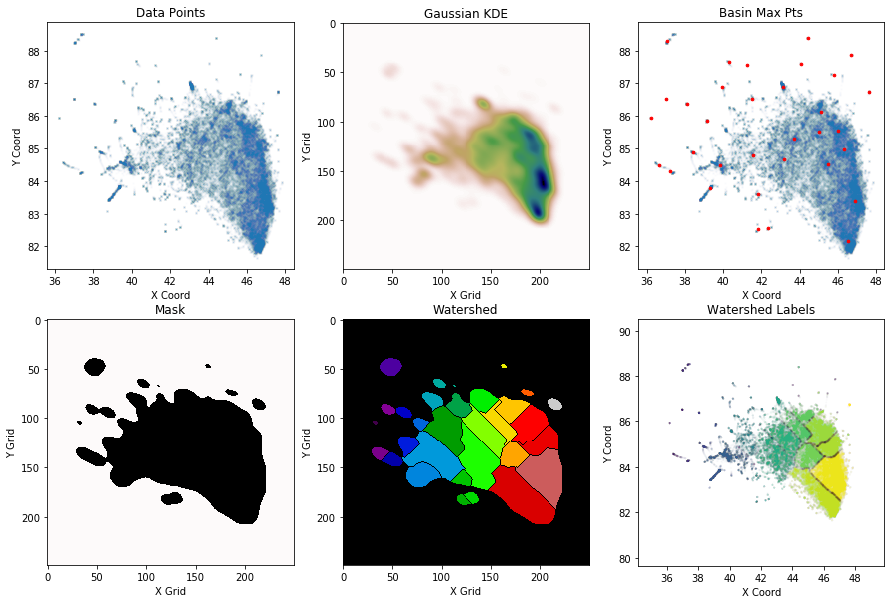

In [19]:
watershed_labels = Watershed(data=region_embed, grid_dim=250, grid_padding=2, verbose=True, fig_alpha=0.01, fig_s=2, watershed_line=True)

  0%|          | 0/33 [00:00<?, ?it/s]/Users/donghur/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/donghur/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
100%|██████████| 33/33 [00:00<00:00, 13247.71it/s]


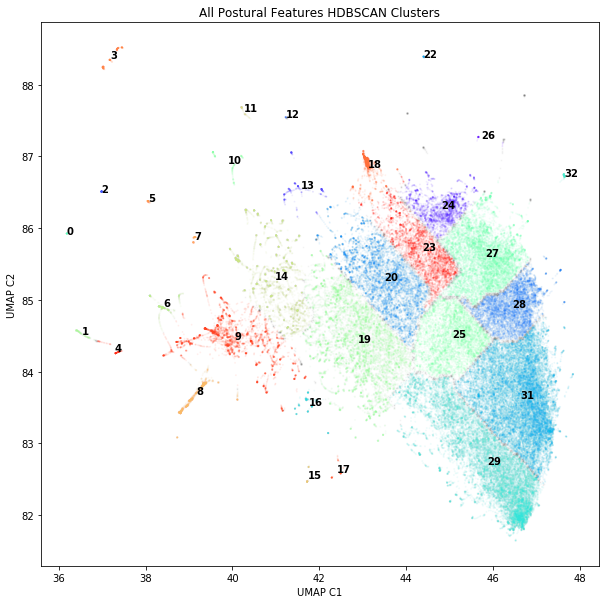

In [20]:
num_clusters = np.max(watershed_labels)+1

color_palette = sns.color_palette('rainbow', int(num_clusters))
color_palette = shuffle(color_palette, random_state=1)

fig, ax = plt.subplots(figsize=(10,10))
plot_HDBSCAN(ax, region_embed, watershed_labels, color_palette, alpha=0.05, toggle_numbering=True)
plt.show()

